In [9]:
import os
import sys 
sys.path.append(os.path.abspath('..'))
from plot import plot_learning2, plot_learning
import matplotlib.pyplot as plt

#%matplotlib qt
#%matplotlib widget
%matplotlib inline

In [13]:
folder_name = 'Sim_simple2'

#ignore = [2] # for loss16
#ignore = [8] # for loss21
ignore = []

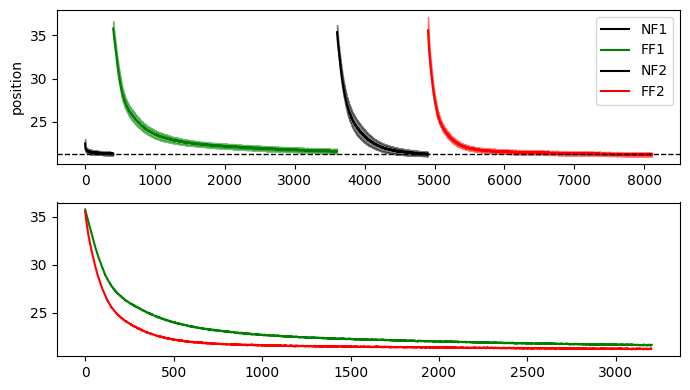

In [12]:

phase = {'NF1':[0],'FF1':[8],'NF2':[0],'FF2':[8]}
folder_name = 'Sim_simple'

fig, ax = plot_learning(folder_name,num_model=20,w=1,phases=phase,loss_type='position',figsize=(7,4),ignore=ignore,show_saving=True)
plt.tight_layout()
plt.show()
#fig.savefig(os.path.join(data_dir,'learning_curve_pos.png'),dpi=300)

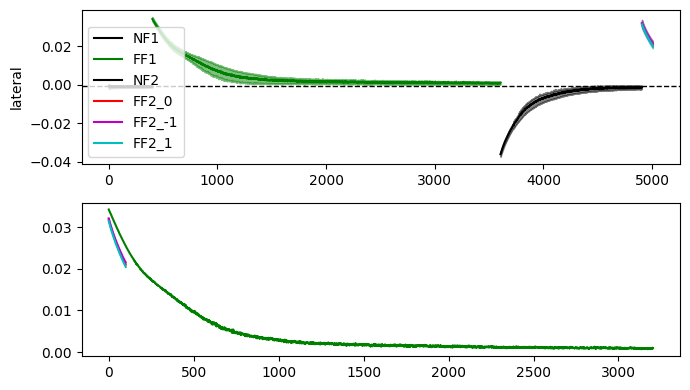

In [14]:
phase = {'NF1':[0],'FF1':[8],'NF2':[0],'FF2':[8]}

fig, ax = plot_learning2(folder_name,num_model=20,w=1,phases=phase,loss_type='lateral',figsize=(7,4),ignore=ignore,show_saving=True)
plt.tight_layout()
plt.show()